In [1]:
from __future__ import print_function

import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,TensorBoard,ReduceLROnPlateau

from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.activations import relu
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras import backend as K
# from tensorflow.keras.datasets import mnist, cifar10
import tensorflow_addons as tfa
from itertools import chain

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from scipy.io import loadmat 
import mat73
from datetime import datetime
import ipynbname

from packaging import version
print("Packages Loaded")

Packages Loaded


In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      #tf_config = tf.ConfigProto(allow_soft_placement=False)
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
import wandb
from wandb.keras import WandbCallback
time_stamp = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
wandb.init(project="my-test-project", entity="ibksolar", name=ipynbname.name()+time_stamp,config ={} )
 
config = wandb.config

wandb: Currently logged in as: ibksolar (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.13.0 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [4]:
# base_path = '..\\..\\all_block_data\Dec_Train_block_len_21_011121_2331'
#base_path = '../all_block_data/Old_data/Dec_Train_block_len_21_231121_1531' '../all_block_data\FindPeaks_data\Dec_Train_block_len_21_030122_0614'

base_path = '../../../Python_Env/final_layers_rowblock15_21/filtered_image'

# Confirm path is right...
print(f'{os.path.isdir(base_path)}')

True


In [5]:
# Load data
# raw_data1 = loadmat('new_echo_cnn_in_out_jstarrs2021_first_try/echo_cnn_in_out_jstars1.mat')
# raw_data1 = loadmat('echo_cnn_in_out_GOOD_layers/new_echo_cnn_in_out_jstars1.mat') 'findpeaks_layers/new_echo_cnn_in_out_jstars1.mat'

raw_data1 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars1.mat')
raw_data2 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars2.mat')
raw_data3 = loadmat('../../../Python_Env/final_layers_rowblock15_21/filtered_image/new_echo_cnn_in_out_jstars3.mat')
# raw_data4 = loadmat('findpeaks_layers_rowblock20/new_echo_cnn_in_out_jstars4.mat')

d1 = raw_data1['echo_cnn1']
t1 = raw_data1['echo_target1']
i1 = raw_data1['echo_idx1']
c1 = raw_data1['coords1']

d2 = raw_data2['echo_cnn2']
t2 = raw_data2['echo_target2']
i2 = raw_data2['echo_idx2']
c2 = raw_data2['coords2']

d3 = raw_data3['echo_cnn3']
t3 = raw_data3['echo_target3']
i3 = raw_data3['echo_idx3']
c3 = raw_data3['coords3']

# d4 = raw_data4['echo_cnn4']
# t4 = raw_data4['echo_target4']
# i4 = raw_data4['echo_idx4']


orig_all_data = np.concatenate( (d1,d2,d3),axis = 0 )
orig_all_target = np.concatenate( (t1,t2,t3),axis = 0 )
orig_all_idx = np.concatenate( (i1,i2,i3),axis = 0 )
coords = np.concatenate( (c1,c2,c3),axis = 0 )

# Set all nan in the data to zero
nan_idx = np.isnan(orig_all_data).any(axis =-1)
orig_all_target[nan_idx] = 0
orig_all_data[ np.isnan(orig_all_data) ]= 0

In [6]:
# Split based on echograms into small dataset representing training and testing.

reduce_test_set = False

all_echo_idx = np.unique(orig_all_idx)

# Start split 
test_echo_idx = list(chain.from_iterable( [ list(range(20*n+1,20*n+20)) for n in range(1,max(all_echo_idx)//20,2) ] ) )

# list(set(test_echo_idx) & set(train_echo_idx))

if reduce_test_set:
    random.Random(13).shuffle(test_echo_idx)
    test_echo_idx = test_echo_idx[:round(0.3*len(test_echo_idx))]
    # Need to get the coords of the shuffled test_echo_idx

# Create train_echo_idx     
train_echo_idx = [int(elem) for elem in all_echo_idx if elem not in test_echo_idx]

# Create new coords idx for each rowblock from all the echograms
val_cnt = [ (orig_all_idx==elem).sum() for elem in train_echo_idx]
new_coords = []
for elem in val_cnt:
    new_coords.append([*range(elem)])
new_coords = np.concatenate(new_coords).ravel()

# Get all idx of echos in train_echo_idx
search_idx = search_idx = np.where(orig_all_idx == train_echo_idx) #np.where( np.in1d(all_idx,train_echo_idx) )
search_idx = list(search_idx[0])

all_data = orig_all_data[search_idx]
all_target = orig_all_target[search_idx]
all_idx = orig_all_idx[search_idx]

np.testing.assert_equal(new_coords.shape[0],all_data.shape[0])

In [7]:
load_new_data = False

if load_new_data:
    raw_data1 = mat73.loadmat(base_path + '/echo_cnn_in_out_jstars.mat')
    all_data = raw_data1['echo_cnn_input']
    all_target = raw_data1['echo_cnn_target']
    all_coords = raw_data1['coords']
    echo_idx =raw_data1['orig_echo_idx']


    # Set all nan in the data to zeroprint(f'Sum of NaNs in data is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')

    print(f'Sum of NaNs in orignally in data is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')
    nan_idx = np.isnan(all_data).any(axis =-1)
    all_target[nan_idx] = 0
    all_data[ np.isnan(all_data) ]= 0

    print(f'Sum of NaNs in data after setting all to 0 is {np.sum(np.any(np.isnan(all_data)))}; in target is {np.sum(np.any(np.isnan(all_target)))} ')

In [8]:
# Standardize all_data
standardize = False
if standardize:
    all_data  = ( all_data - all_data.mean() ) / all_data.std()

scale_data = False
if scale_data:
    all_data = 255*all_data

In [9]:
# Truncate data because data after truncate point is notgood for training
truncate_data = False
if truncate_data:    
    echo_idx = np.asarray(echo_idx)
    stop_val = 400

    stop_list, = np.where(echo_idx == stop_val)
    stop_idx = stop_list[-1]

    all_data = all_data[:stop_idx]
    all_target = all_target[:stop_idx]
    all_coords = all_coords[:stop_idx]
    echo_idx = echo_idx[:stop_idx]

    print(f'Data shape {all_data.shape}')
    print(f'Target shape {all_target.shape}')

In [10]:
config['row_length'] = 21 # CHANGE HERE <==
config['col_length'] = 15

# Check that the dimension of data is correct
if all_data.shape[1] == config['row_length']*config['col_length']:
    print('Dimensions match')
else:
    print(f' Row block length:{config["row_length"]} and col length:{config["col_length"]} does not match Data dimension:{all_data.shape[1]}') 
        

Dimensions match


In [11]:
# Positional Encoding
if 0:
    time_seq = config['col_length'] #5
    # all_coords = raw_data1['coords']
    all_coord_exp = np.zeros((all_coords.shape[0],time_seq,config['row_length']))

    for idx in range(len(all_coords)):
        a,b,c,_ = np.asarray(all_coords[idx],dtype="int")
        if (a%2) == 0: # If row index is even - this isn't implemented well because it requires iterating through individual rows
            all_coord_exp[idx] = np.sin( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/config['row_length'])) ) )
        else:
            all_coord_exp[idx] = np.cos( np.outer( np.arange(c,c+time_seq), pow(10000, (2*np.arange(a,b)/config['row_length'])) ) )

    if 0: #truncate_data:
        difficult_coords = all_coord_exp[stop_idx+1:]         
        all_coord_exp = all_coord_exp[:stop_idx]        


    all_coord_exp.shape    

In [36]:
seq_length = 21

# Create Coords matrix to be used for Positional Embedding
new_coords_mtx = np.zeros( (len(new_coords),seq_length) )

for idx,each_coord in enumerate(new_coords):
    new_coords_mtx[idx] = np.linspace(0, each_coord, num=seq_length) #max([0,each_coord-1])

In [37]:
max_class = config['row_length'] 

# Highest class is mapped to row_length+1
all_target[all_target == max_class+1 ] = 0


shuffle = 1
if shuffle:
    random.Random(13).shuffle(all_data)
    random.Random(13).shuffle(all_target)
    # random.Random(13).shuffle(all_coord_exp)
    random.Random(13).shuffle(new_coords_mtx)

## Prep data
train_size = int(np.floor(0.8*len(all_target)));
test_size = int(np.round( 0.15* all_data.shape[0] ))
val_size = all_data.shape[0] -train_size - test_size

mid_pt = 8
neigh =  4

x_train = all_data[0:train_size,:]
x_train = np.reshape( x_train, (x_train.shape[0],max_class,-1),order ='F' )
x_train = x_train[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_train = np.reshape(x_train,(x_train.shape[0],-1))
#x_train = np.transpose(x_train,(0,2,1))
coords_train = new_coords_mtx[0:train_size,:]


x_test = all_data[train_size:train_size+test_size,:]
x_test = np.reshape( x_test,(x_test.shape[0],max_class,-1), order ='F' )
x_test = x_test[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_test = np.reshape(x_test,(x_test.shape[0],-1))
#x_test = np.transpose(x_test,(0,2,1))
coords_test = new_coords_mtx[train_size:train_size+test_size,:]


x_val = all_data[-val_size:,:]
x_val = np.reshape( x_val,(x_val.shape[0],max_class,-1), order ='F' )
x_val = x_val[:,:,mid_pt-neigh:mid_pt+neigh+1]
# x_val = np.reshape(x_val,(x_val.shape[0],-1))
#x_val = np.transpose(x_val,(0,2,1))
coords_val = new_coords_mtx[-val_size:,:]


y_train = all_target[:train_size]
y_test  = all_target[train_size:train_size+test_size]
y_val = all_target[-val_size:]

var_input_shape = x_train.shape[1:] # 240 columns
num_classes = max_class+1 # layers


# Convert labels to categorical orthonormal vectors
y_train_1hot = tf.keras.utils.to_categorical(y_train, num_classes)
y_test_1hot  = tf.keras.utils.to_categorical(y_test, num_classes)

print(f'Shape of X_train:{x_train.shape}  X_test:{x_test.shape}')
print(f'Shape of y_train:{y_train.shape}  y_test:{y_test.shape}')

Shape of X_train:(887347, 21, 9)  X_test:(166378, 21, 9)
Shape of y_train:(887347, 1)  y_test:(166378, 1)


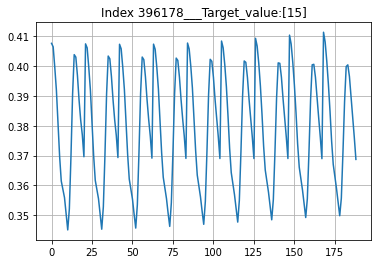

In [14]:
# Visualize some of the input
rand_idx = random.choice( range(1,x_train.shape[0]) )
_ = plt.plot(x_train[rand_idx].flatten())
_ = plt.title(f'Index {rand_idx}___Target_value:{y_train[rand_idx]}' )
_ = plt.grid(which='both')

In [15]:
# Populate the param log
log ={}
log['Notebook_name'] = ipynbname.name()
#log['Uniqueness_of_each_run'] = "New Attention,Hoping for better performance; Aug2022 :("
log['base_dir'] = base_path
log['Train_shape'] = x_train.shape
log['Output_shape'] = ''
log['num_epochs'] = ''
log['batch_size'] = ''
log['activation_function'] = ''
log['optimizer'] = ''
log['learning_rate'] = ''
log['loss_finction'] = ''
log['accuracy'] = []
log['loss'] = []
log['stop_time'] = ''
log['Model_config'] = ''
log['Performance_on_test_set'] = ''
log['output_path'] = ''  # output: where the trained model is saved
log['shuffle'] = shuffle
log['run_completion_comment'] = '' # Comment on training and probably evaluation too

from model_hyper_param_log import create_log_entry,update_log_entry
if "log_idx" in globals():
    log["S_N"] = log_idx
log_idx = create_log_entry('../testing_sheet2.xlsx', log)

Could not get file name: auto-generating name
Activation_function not in workspace
loss_function not in workspace
Accuracy_per_epoch not in workspace
Loss_per_epoch not in workspace
Stop_time not in workspace
extras  is not in workspace
Current run hyper_params are dict_keys(['S_N', 'Start_time', 'NoteBook_name', 'Uniqueness_of_each_run', 'Base_dir', 'Train_shape', 'Output_shape', 'num_epochs', 'Activation_function', 'optimizer', 'learning_rate', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop_time', 'Model_config', 'Performance_on_test_set', 'output_path', 'shuffle', 'Computer_name', 'extras']):dict_values([94, '04_August_22_1131', 'NewAttention_RowBlock_Feb2022_ReMake-Copy1', '', '../../../Python_Env/final_layers_rowblock15_21/filtered_image', (887347, 9, 21), '', '', '', '', '', '', '', '', '', '', '', '', 1, 'AQ-98JH673', ''])
Fields to be updated include: ['Uniqueness_of_each_run', 'Activation_function', 'loss_function', 'Accuracy_per_epoch', 'Loss_per_epoch', 'Stop

In [16]:
# View current config 
config

{'row_length': 21, 'col_length': 15}

In [17]:
config['batch_size'] = batch_size= 512
AUTO = tf.data.AUTOTUNE
#BUFFER = config['batch_size'] * 4

combined_train= (x_train, coords_train)
combined_test = (x_test, coords_test)
combined_val  = (x_val, coords_val)

train_ds = tf.data.Dataset.from_tensor_slices(
    ( {"echo":x_train,"coords":coords_train}, y_train))
train_ds = train_ds.batch(batch_size,drop_remainder=True).prefetch(AUTO)

#PS: Using created "test data" as the validation data seen during training
val_ds = tf.data.Dataset.from_tensor_slices(({"echo":x_test,"coords":coords_test}, y_test))
val_ds = val_ds.batch(batch_size).prefetch(AUTO)

#test_ds = tf.data.Dataset.from_tensor_slices((x_test,y_test))
#test_ds = test_ds.batch(BUFFER).prefetch(AUTO)

In [ ]:
# Model and training

class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        
        self.attention1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim*5)
        
        self.attention2 = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_dim)
        
        self.dense_proj = tf.keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(dense_dim, activation="relu"),
             layers.Dense(dense_dim//2, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Repeat attention K times        
        attention_output1 = inputs # New copy to be over-written
        for _ in range(10):
            attention_output1 = self.attention1(
            attention_output1, attention_output1, attention_mask=mask)            
        
        # # Repeat attention K times 
        # attention_output = attention_output1 # New copy to be over-written
        # for _ in range(5):
        #     attention_output = self.attention2(
        #     attention_output, attention_output, attention_mask=mask)
        
        proj_input = self.layernorm_1(inputs + attention_output1)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

#  Default hyper-param
config['epochs'] = 500
config['batch_size'] = 128
config['learning_rate'] = 1e-3 

proj_head_units = [1024, 512, 64, input_shape[-1]] 
mlp_head_units = proj_head_units[-2:]

# Model hyper-param
embed_dim = input_shape[-1] #21
num_heads = 10
dense_dim = 768

# Create Model
input_shape = (x_train.shape[1:])
pos_input_shape = (coords_train.shape[1:])

dense_proj = tf.keras.Sequential()
for units in proj_head_units:
    dense_proj.add(layers.Dense(units, activation='relu', use_bias=True) )
    
mlp_head = tf.keras.Sequential()
for units in mlp_head_units:
    mlp_head.add(layers.Dense(units, activation='relu', use_bias=True) )

echo_inputs = tf.keras.Input(shape=input_shape)
pos_inputs = tf.keras.Input(shape= pos_input_shape)

pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[-1])(pos_inputs)
#pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[0])(pos_inputs)

x = echo_inputs + pos_embedding
x = dense_proj(x)
res = x # Keep a residual branch

for _ in range(15):
    x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
    x = x + res
    x = layers.Normalization()(x)
    x = mlp_head(x)
    
x = dense_proj(x)
x = layers.Flatten()(x) #layers.GlobalAveragePooling1D()

x = layers.Dense(dense_dim, activation= tf.nn.gelu)(x) #tf.nn.gelu
x = layers.Dense(dense_dim, activation= "relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model = tf.keras.Model([echo_inputs,pos_inputs], outputs)

config['start_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')


# Update Hyper parameter log
config['input_shape'] = input_shape
config['pos_input_shape'] = pos_input_shape
config['embed_dim'] = embed_dim
config['num_heads'] = num_heads
config['dense_dim'] = dense_dim


# Model and Checkpoint path
model_save_path = os.path.join(os.path.dirname(os.getcwd()), r'all_block_data\PulsedTrainTest')
logs = model_save_path+'/'+ipynbname.name()+f"/{config['start_time']}_logs/" 
logs = logs.replace(os.sep,'/')
# Callbacks
callbacks = [
    ModelCheckpoint(model_save_path+'/'+ipynbname.name()+f"/{config['start_time']}_Checkpoint.h5", save_best_only=True, monitor="val_loss"),
    ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=15, min_lr=0.0001),
    EarlyStopping(monitor="val_loss", patience=60, verbose=1), 
    TensorBoard(log_dir = logs,histogram_freq = 1,profile_batch = '50,70', embeddings_freq=50),
    WandbCallback()
]

opt1 = Adam (learning_rate=config['learning_rate'],)
opt4 = tfa.optimizers.AdamW(weight_decay = 0.0001, learning_rate=config['learning_rate'],)

top_K = 3


print(f'Training start time:{config["start_time"]}')

model.compile( optimizer = opt1, loss="categorical_crossentropy", metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")],) # sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)

#[x_train,coords_train], y_train_1hot
history = model.fit([x_train,coords_train], y_train_1hot,
          epochs= config['epochs'], 
          batch_size= config['batch_size'], 
          validation_data=([x_test,coords_test], y_test_1hot),
         callbacks=callbacks)

config['end_time'] = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
print(f'End time {config["end_time"]}')

Training start time:08_August_22_0920
Epoch 1/500
6933/6933 [==============================] - 2729s 390ms/step - loss: 1.2001 - accuracy: 0.5189 - top-3-accuracy: 0.8812 - val_loss: 1.0554 - val_accuracy: 0.5830 - val_top-3-accuracy: 0.9180
Epoch 2/500
6933/6933 [==============================] - 2682s 387ms/step - loss: 1.0319 - accuracy: 0.5822 - top-3-accuracy: 0.9173 - val_loss: 1.0692 - val_accuracy: 0.5797 - val_top-3-accuracy: 0.9165
Epoch 3/500
6933/6933 [==============================] - 2683s 387ms/step - loss: 0.9515 - accuracy: 0.6140 - top-3-accuracy: 0.9311 - val_loss: 0.9555 - val_accuracy: 0.6241 - val_top-3-accuracy: 0.9339
Epoch 4/500
6933/6933 [==============================] - 2681s 387ms/step - loss: 1.0501 - accuracy: 0.5809 - top-3-accuracy: 0.8988 - val_loss: 1.6683 - val_accuracy: 0.3610 - val_top-3-accuracy: 0.7490
Epoch 5/500
6933/6933 [==============================] - 2682s 387ms/step - loss: 1.5203 - accuracy: 0.4003 - top-3-accuracy: 0.7859 - val_loss: 1

In [ ]:
# Legacy Script: Should delete after harvesting

if 0:
    # Create Custom Model for Attention from base LSTM model
    loaded_model = tf.keras.models.load_model(r"Y:\\ibikunle\\Python_Project\\Fall_2021\all_block_data\Filteredfiltered_data\LSTM1_RepeatExactly\27_January_22_2325_RowBlockLSTM_checkpoint.h5")
    for i in range(80):
        loaded_model.layers[i].trainable = False

    # Patch Embedding
    class PatchEmbedding(layers.Layer):
        def __init__(self, num_patch, embed_dim, **kwargs):
            super(PatchEmbedding, self).__init__(**kwargs)
            self.num_patch = num_patch
            self.proj = layers.Dense(embed_dim)
            self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

        def call(self, patch):
            pos = tf.range(start=0, limit=self.num_patch, delta=1)
            print(f"Num patches {self.num_patch}: Pos {pos.shape}")
            return self.proj(patch) + self.pos_embed(pos)


    def ResNetBlock(x,nodes):
        #x =   layers.Conv2D(filters=64, kernel_size=3, padding="same")(x) #input_layer
        conv1 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(x) # input_layer, Conv1D
        conv1 = layers.BatchNormalization()(conv1)
        conv1 = layers.ReLU()(conv1)

        conv2 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv1)
        conv2 = layers.BatchNormalization()(conv2)
        conv2 = layers.ReLU()(conv2)

        conv3 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv2)
        conv3 = layers.BatchNormalization()(conv3)
        conv3 = layers.ReLU()(conv3)

    #     conv4 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv3)
    #     conv4 = layers.BatchNormalization()(conv4)
    #     conv4 = layers.ReLU()(conv4)

    #     conv5 = layers.Conv2D(filters=nodes, kernel_size=3, padding="same")(conv4)
    #     conv5 = layers.BatchNormalization()(conv5)
    #     conv5 = layers.ReLU()(conv5)

        conv3 = layers.add([x,conv3])
        x = layers.ReLU()(conv3) # Overwrite x

        return x

    def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
        # Attention and Normalization
        x = layers.MultiHeadAttention(
            key_dim=head_size, num_heads=num_heads, dropout=dropout
        )(inputs, inputs)
        x = layers.Dropout(dropout)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        res = x + inputs

        # Feed Forward Part
        x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(res)
        x = layers.Dropout(dropout)(x)
        x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
        x = layers.LayerNormalization(epsilon=1e-6)(x)
        return x + res

    def build_model(
        input_shape,
        head_size,
        num_heads,
        ff_dim,
        num_transformer_blocks,
        mlp_units,
        nodes,
        dropout=0,
        mlp_dropout=0,    
    ):
        inputs = tf.keras.Input(shape=input_shape)
        pos_input = tf.keras.Input(shape=(None,))

        pos_embedding = layers.Embedding(input_dim = np.max(new_coords), output_dim = input_shape[-1])(pos_input)

        inputs = inputs + pos_embedding

        # for _ in range(resnet_heads):
        #     x = ResNetBlock(x,ff_dim)

        x = layers.LSTM(512,recurrent_dropout= 0, return_sequences=True)(inputs)   

        for _ in range(num_transformer_blocks):
            x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)   

        #x = tf.reduce_sum(x,axis=-1)
        x = layers.GlobalAveragePooling1D()(x)
        for dim in mlp_units:
            x = layers.Dense(dim, activation="relu")(x)
            x = layers.Dropout(mlp_dropout)(x)    

        outputs = layers.Dense(num_classes, activation="softmax")(x)
        return tf.keras.Model([inputs,pos_input], outputs)


    input_shape = (x_train.shape[1:]) # + (1,)  input_shape = (21,5,) #x_train.shape[2] 

    # ResNet params
    resnet_heads = 10

    # Checkpoint path
    base_path2 = r'Y:\ibikunle\Python_Project\Fall_2021\all_block_data\PulsedTrainTest'

    # Attention params
    num_epochs = 150
    batch_size = 128
    nodes = 64 #512
    learning_rate = 5e-2

    head_size = 64 # 256,64
    num_heads = 4
    ff_dim= 64
    num_transformer_blocks= 4
    mlp_units= [512,1024]  # 128,512
    mlp_dropout=0.1    #0.4
    dropout=0.1          #0.25

    model = build_model(input_shape,head_size=head_size,num_heads=num_heads,ff_dim=ff_dim,
                        num_transformer_blocks = num_transformer_blocks,
                        mlp_units=mlp_units, nodes=nodes, 
                        mlp_dropout=mlp_dropout, dropout=dropout)

    wandb.config = {
      "learning_rate": "learning_rate",
      "epochs": num_epochs, 
      "batch_size": batch_size,
      "nodes": nodes,
      "config['row_length']":row_length,
      "base_path":base_path,
      "head_size":head_size, "num_heads":num_heads,
      "ff_dim":ff_dim, "num_transformer_blocks":num_transformer_blocks,
      "mlp_units":mlp_units, "mlp_dropout":mlp_dropout,
      "dropout":dropout
    }


    # Poly Rate scheduler
    starter_learning_rate = 0.001
    end_learning_rate = 0.0001
    decay_steps = 1000
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
        starter_learning_rate,
        decay_steps,
        end_learning_rate,
        power=0.25)

    # Callbacks
    callbacks = [
        ModelCheckpoint(base_path2+'/'+ipynbname.name()+"/best_model.h5", save_best_only=True, monitor="val_loss"),
        ReduceLROnPlateau(monitor="val_loss", factor=0.05, patience=10, min_lr=0.0001),
        #EarlyStopping(monitor="val_loss", patience=25, verbose=1), 
        WandbCallback()
    ]

    # Trying different optimizers
    opt1 = tf.keras.optimizers.RMSprop(learning_rate=learning_rate,rho=0.9,momentum=0.9, epsilon=1e-07,centered=True,name="RMSprop")
    opt2 = tf.keras.optimizers.Adam(learning_rate=learning_rate,amsgrad=True)
    opt3 = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True, name="SGD")
    opt4 = tfa.optimizers.AdamW(weight_decay = 0.0001, learning_rate=learning_rate,)

    poly_rate = tf.keras.optimizers.SGD(learning_rate = learning_rate_fn)
    poly_rate2 = tf.keras.optimizers.Adam(learning_rate = learning_rate_fn)
    top_K = 3

    start_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H%M')
    print(f'Training start time:{start_time}')

    # model.compile( optimizer = opt, loss= 'categorical_crossentropy', metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")])  #label_smoothing=0.05, tf.keras.losses.KLDivergence()
    #model.compile( optimizer=opt1,loss="sparse_categorical_crossentropy" , metrics=["sparse_categorical_accuracy"],) #"sparse_categorical_crossentropy" , sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
    model.compile( optimizer = opt4, loss="categorical_crossentropy" , metrics=['accuracy',tf.keras.metrics.TopKCategoricalAccuracy(top_K, name="top-3-accuracy")],) # sparse_categorical_accuracy", tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.3)
    #Adam(amsgrad=True), loss="categorical_crossentropy"  optimizer=opt2,loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2)

    history = model.fit([x_train,new_coords_mtx], y_train_1hot,
              epochs= num_epochs, 
              batch_size= batch_size, 
              validation_data=(x_test, y_test_1hot),
             callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

    # Update manual log file
    params_to_be_updated = update_log_entry('../testing_sheet2.xlsx', log_idx, model, history)

    # Update model with the best from Callbacks
    model = tf.keras.models.load_model(base_path2+'/'+ipynbname.name()+"/best_model.h5")

    end_time = datetime.strftime( datetime.now(),'%d_%B_%y_%H_%M')
    print(f'End time {end_time}')

    # Previous accuracy before using Findpeaks data was 12%

In [ ]:
log['Uniqueness_of_each_run'] = 'Attention Finished at 60% but lower loss. Removed label smoothing too'
run_completion_comment = f''
if "log_idx" in globals():
    log["S_N"] = log_idx
    log['run_completion_comment'] = run_completion_comment
    log_idx = create_log_entry('../testing_sheet2.xlsx', log)

In [21]:

import random
check_start = random.randint(0,len(x_val))

print(f'Check start idx: {check_start}')
[ (y_val[idx], np.argmax( model.predict([np.expand_dims(x_val[idx],axis=0), np.expand_dims(coords_val[idx],axis=0)])) ) for idx in range(check_start,check_start+20) ]


--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1087, in emit
    self.flush()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1067, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\cresis\

Check start idx: 8415


[(array([14], dtype=uint8), 15),
 (array([13], dtype=uint8), 13),
 (array([19], dtype=uint8), 19),
 (array([14], dtype=uint8), 14),
 (array([15], dtype=uint8), 15),
 (array([15], dtype=uint8), 15),
 (array([13], dtype=uint8), 14),
 (array([15], dtype=uint8), 15),
 (array([0], dtype=uint8), 0),
 (array([16], dtype=uint8), 16),
 (array([9], dtype=uint8), 9),
 (array([11], dtype=uint8), 12),
 (array([16], dtype=uint8), 17),
 (array([8], dtype=uint8), 9),
 (array([11], dtype=uint8), 11),
 (array([0], dtype=uint8), 0),
 (array([14], dtype=uint8), 14),
 (array([14], dtype=uint8), 14),
 (array([8], dtype=uint8), 8),
 (array([9], dtype=uint8), 9)]

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1087, in emit
    self.flush()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\logging\__init__.py", line 1067, in flush
    self.stream.flush()
OSError: [Errno 22] Invalid argument
Call stack:
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\cresis\.conda\envs\TF_2.8\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
    self.io_loop.start()
  File "C:\Users\cresis\

In [43]:
test_model = tf.keras.models.load_model(r"Y:\ibikunle\Python_Project\Fall_2021\Fall_2021\all_block_data\PulsedTrainTest\NewAttention_RowBlock_Feb2022_ReMake\01_March_22_2138_Checkpoint.h5", custom_objects={"TransformerEncoder":TransformerEncoder})

y_val = all_target[-val_size:]
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
_, accuracy,top_3_acc = test_model.evaluate([x_val,coords_val], y_val)
print(f"Test accuracy: {round(accuracy * 100, 2)}%")
# print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")
print(f"Test_time: {datetime.strftime(datetime.now(),'%d_%B_%y_%H%M')}")

_,new_col_length,new_row_length = x_train.shape
#model.save(f'{base_path2}//{ipynbname.name()}//{time_stamp}_Acc_{accuracy:.3f}_Top3Acc{top3_acc:.3f}_{new_row_length}x{new_col_length}.h5')

2947/2947 [==============================] - 299s 100ms/step - loss: 2.2690 - accuracy: 0.4150 - top-3-accuracy: 0.7868
Test accuracy: 41.5%
Test_time: 17_March_22_1359


In [ ]:
history2 = model.fit(x_train, y_train_1hot,
      epochs= 350, 
      batch_size= config['batch_size'], 
      validation_data=(x_test, y_test_1hot),
     callbacks=callbacks)

In [ ]:
# Train further
if accuracy < 0.7:
    history = model.fit(x_train, y_train,
          epochs= 20, 
          batch_size= batch_size, 
          validation_data=(x_test, y_test),
         callbacks=callbacks) #mcp_save, callbacks=[reduce_lr_loss]

In [ ]:
# Test model manually on all val data

y_pred = [ np.argmax( model.predict([np.expand_dims(x_val[idx],axis=0), np.expand_dims(coords_val[idx],axis=0)])) for idx in range(len(x_val)) ]

combined_result = zip(y_val,y_pred)

val_exact_accuracy = 100 * sum([1 if y_pred[idx]==y_val[idx]   else 0 for idx in range(len(y_pred)) ]) / len(y_pred)
val_margin3_accuracy = 100 * sum([1 if abs(y_pred[idx]-y_val[idx]) < 3 else 0 for idx in range(len(y_pred)) ]) / len(y_pred)

print(f' Exact accuracy is {val_exact_accuracy: .5f} %')
print(f' Top 3% accuracy is {val_margin3_accuracy: .5f} %')

In [ ]:
# Confusion Matrix and ROC/AUC

model_predictions = np.asarray(y_pred)
ground_truth = y_val.squeeze()

# Prediction per Ground-truth class
class_predictions = [ model_predictions[ground_truth==idx]  for idx in range(num_classes) ]

# Confusion matrix
confusion_mtx = np.zeros((num_classes,num_classes) )

for pred,actual in zip(y_pred,y_val): # Rows=Prediction, Columns = Actual
    confusion_mtx[pred,actual] +=1

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig, ax = plt.subplots(figsize=(7,15),dpi = 100);
shw=ax.imshow(confusion_mtx)
#bar= plt.colorbar(shw)

_=plt.ylabel('Predictions')
_=plt.xlabel('Actual Class')
_=plt.title('Confusion matrix')

# ax.set_xticklabels(list(range(num_classes)))
# ax.set_yticklabels(list(range(num_classes)))

# Create an axes on the right side of ax. The width of cax will be 5%
# of ax and the padding between cax and ax will be fixed at 0.05 inch.
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
#bar.set_label('ColorBar')
_ = plt.colorbar(shw, cax=cax)

In [ ]:
# Histogram of each class prediction
for idx,each_class in enumerate(class_predictions):
    _ = plt.figure()
    _ = plt.title('Class %s'%idx)
    labels, counts = np.unique(each_class, return_counts=True)
    _ = plt.bar(labels, counts, align='center')
    _ = plt.gca().set_xticks(labels)
    _ = plt.show()

In [ ]:
from sklearn.metrics import classification_report

print( classification_report( y_val,y_pred, labels=list(range(num_classes)), zero_division=1 ))